In [7]:
# Import libraries
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import seaborn as sns
from glob import glob
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline

In [8]:
# Prepare the data by building the wrangle function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
    
    # Subset data: Apartments in "Distrito Federal", less than $100,000
    mask_apt = df["property_type"] == "apartment"
    mask_df = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price = df["price_aprox_usd"] < 100_000
    df = df[mask_apt & mask_df & mask_price]
    
    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    # Get borough name
    df["borough"] = df["place_with_parent_names"].str.split("|", expand=True)[1]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop columns with more than 50% null values
    df.drop(columns=["surface_total_in_m2", "price_usd_per_m2", "floor", "rooms", "expenses"], inplace=True)
    
    # Drop columns with low- or high-cardinality categorical values
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop columns with leakage for the target "price_aprox_usd"
    df.drop(columns=[
        "price",
        "price_aprox_local_currency",
        "price_per_m2"
    ], inplace=True)
    
    return df

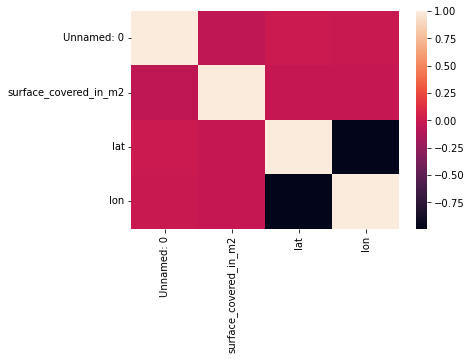

In [13]:
# Test the wrangle function and explore the data
df = wrangle("data/mexico-city-real-estate-1.csv")
sns.heatmap(df.select_dtypes("number").drop(columns="price_aprox_usd").corr());

In [14]:
# Use glob to create the list files
files = glob("data/mexico-city-real-estate-*.csv")
files

['data\\mexico-city-real-estate-1.csv',
 'data\\mexico-city-real-estate-2.csv',
 'data\\mexico-city-real-estate-3.csv',
 'data\\mexico-city-real-estate-4.csv',
 'data\\mexico-city-real-estate-5.csv']

In [15]:
# Use the wrangle function on the files and concatenate them to create the Dataframe
frames = [wrangle(file) for file in files]
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5473 non-null   int64  
 1   price_aprox_usd        5473 non-null   float64
 2   surface_covered_in_m2  5473 non-null   float64
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
 5   borough                5473 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 256.7+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,12,94022.66,57.0,23.634501,-102.552788,Benito Juárez
1,21,70880.12,56.0,19.402413,-99.095391,Iztacalco
2,22,68228.99,80.0,19.357820,-99.149406,Benito Juárez
3,23,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
4,27,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [16]:
# Drop the Unnamed column
df.drop(columns="Unnamed: 0", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
